In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#export
from nb_001b import *
import sys, PIL, matplotlib.pyplot as plt, itertools, math, random, collections, torch
import scipy.stats, scipy.special

from enum import Enum, IntEnum
from torch import tensor, FloatTensor, LongTensor, ByteTensor, DoubleTensor, HalfTensor, ShortTensor
from operator import itemgetter, attrgetter
from numpy import cos, sin, tan, tanh, log, exp

from functools import reduce
from collections import defaultdict, abc, namedtuple, Iterable
from PIL import Image

# CIFAR subset data

## Setup

In [3]:
DATA_PATH = Path('data')
PATH = DATA_PATH/'cifar10_dog_air'
TRAIN_PATH = PATH/'train'

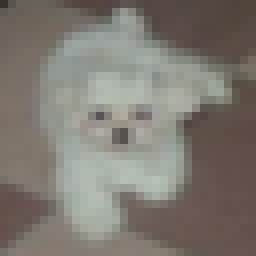

In [4]:
dog_fn = list((TRAIN_PATH/'dog').iterdir())[0]
dog_image = Image.open(dog_fn)
dog_image.resize((256,256))

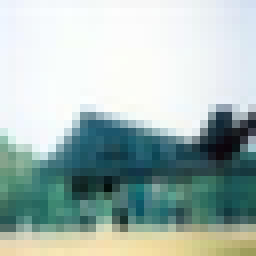

In [5]:
air_fn = list((TRAIN_PATH/'airplane').iterdir())[0]
air_image = Image.open(air_fn)
air_image.resize((256,256))

## Simple Dataset/Dataloader

In [6]:
#export
def find_classes(folder):
    classes = [d for d in folder.iterdir()
               if d.is_dir() and not d.name.startswith('.')]
    assert(len(classes)>0)
    return sorted(classes, key=lambda d: d.name)

def get_image_files(c):
    return [o for o in list(c.iterdir())
            if not o.name.startswith('.') and not o.is_dir()]

def pil2tensor(image):
    arr = torch.ByteTensor(torch.ByteStorage.from_buffer(image.tobytes()))
    arr = arr.view(image.size[1], image.size[0], -1)
    arr = arr.permute(2,0,1)
    return arr.float().div_(255)

In [7]:
#export
class FilesDataset(Dataset):
    def __init__(self, folder, classes=None):
        self.fns, self.y = [], []
        if classes is None: classes = [cls.name for cls in find_classes(folder)]
        self.classes = classes
        for i, cls in enumerate(classes):
            fnames = get_image_files(folder/cls)
            self.fns += fnames
            self.y += [i] * len(fnames)
        
    def __len__(self): return len(self.fns)

    def __getitem__(self,i):
        x = PIL.Image.open(self.fns[i]).convert('RGB')
        return pil2tensor(x),self.y[i]

In [8]:
train_ds = FilesDataset(PATH/'train')
valid_ds = FilesDataset(PATH/'test')

In [9]:
len(train_ds), len(valid_ds)

(10000, 2000)

In [10]:
#export
def image2np(image): return image.cpu().permute(1,2,0).numpy()

airplane


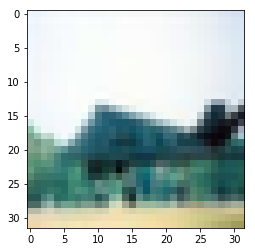

In [11]:
x,y = train_ds[0]
plt.imshow(image2np(x))
print(train_ds.classes[y])

In [12]:
bs=64

In [13]:
data = DataBunch(train_ds, valid_ds, bs=bs)
len(data.train_dl), len(data.valid_dl)

(157, 16)

In [14]:
#export
def show_image(img, ax=None, figsize=(3,3), hide_axis=True):
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(image2np(img))
    if hide_axis: ax.axis('off')

def show_image_batch(dl, classes, rows=None, figsize=(12,15)):
    if rows is None: rows = int(math.sqrt(len(x)))
    x,y = next(iter(dl))[:rows*rows]
    show_images(x,y,rows, classes)

def show_images(x,y,rows, classes, figsize=(9,9)):
    fig, axs = plt.subplots(rows,rows,figsize=figsize)
    for i, ax in enumerate(axs.flatten()):
        show_image(x[i], ax)
        ax.set_title(classes[y[i]])
    plt.tight_layout()

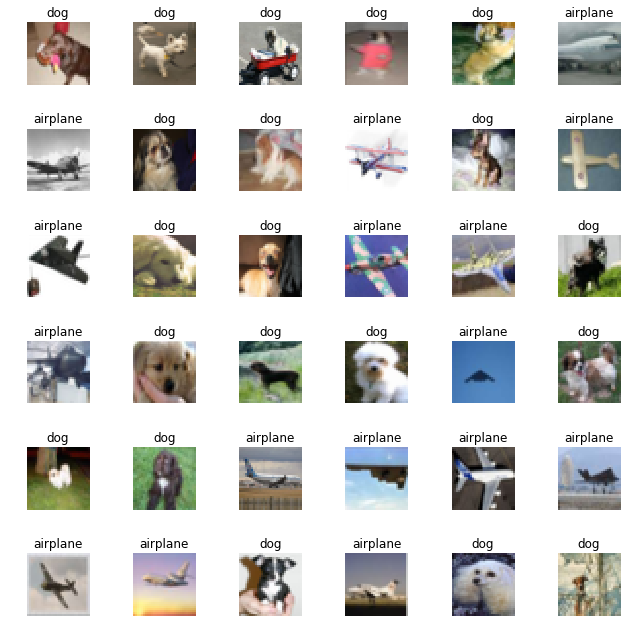

In [15]:
show_image_batch(data.train_dl, train_ds.classes, 6)

# Data augmentation

## Lighting

In [16]:
#export
def logit(x): return (x/(1-x)).log()
def logit_(x): return (x.div_(1-x)).log_()

def brightness(x, change): return x.add_(scipy.special.logit(change))
def contrast(x, scale): return x.mul_(scale)

def apply_lighting(func): return lambda x: func(logit_(x)).sigmoid()

In [17]:
def apply_contrast(scale): return apply_lighting(partial(contrast, scale=scale))

In [18]:
x = lambda: train_ds[1][0]

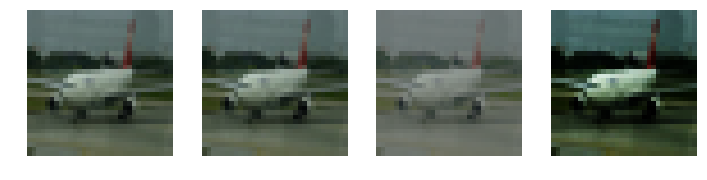

In [19]:
_,axes = plt.subplots(1,4, figsize=(12,3))

show_image(x(), axes[0])
show_image(apply_contrast(1.0)(x()), axes[1])
show_image(apply_contrast(0.5)(x()), axes[2])
show_image(apply_contrast(2.0)(x()), axes[3])

In [20]:
def apply_brightness(change):
    return apply_lighting(partial(brightness, change=change))

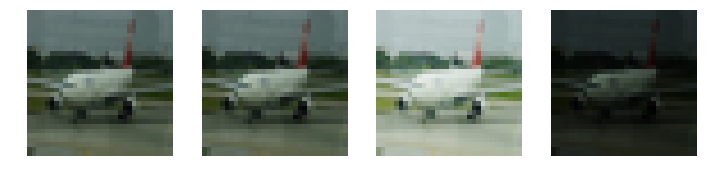

In [21]:
_,axes = plt.subplots(1,4, figsize=(12,3))

show_image(x(), axes[0])
show_image(apply_brightness(0.5)(x()), axes[1])
show_image(apply_brightness(0.8)(x()), axes[2])
show_image(apply_brightness(0.2)(x()), axes[3])

In [22]:
#export
def listify(p=None, q=None):
    if p is None: p=[]
    elif not isinstance(p, Iterable): p=[p]
    n = q if type(q)==int else 1 if q is None else len(q)
    if len(p)==1: p = p * n
    return p

def compose(funcs):
    return reduce(lambda f, g: lambda z: f(g(z)), listify(funcs), lambda o: o)

In [23]:
def apply_brightness_contrast(scale_contrast, change_brightness):
    return apply_lighting(compose([
        partial(contrast, scale=scale_contrast),
        partial(brightness, change=change_brightness)
    ]))

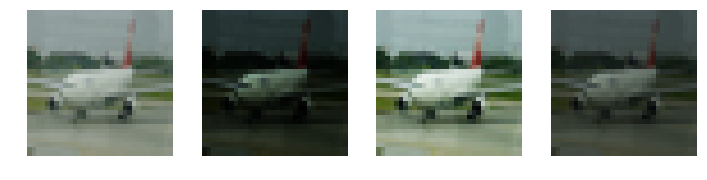

In [24]:
_,axes = plt.subplots(1,4, figsize=(12,3))

show_image(apply_brightness_contrast(0.75, 0.7)(x()), axes[0])
show_image(apply_brightness_contrast(1.3,  0.3)(x()), axes[1])
show_image(apply_brightness_contrast(1.3,  0.7)(x()), axes[2])
show_image(apply_brightness_contrast(0.75, 0.3)(x()), axes[3])

## Random lighting

In [25]:
#export
def uniform(low, high, size=None):
    return random.uniform(low,high) if size is None else torch.FloatTensor(size).uniform_(low,high)

def log_uniform(low, high, size=None):
    res = uniform(log(low), log(high), size)
    return exp(res) if size is None else res.exp_()

def rand_bool(p, size=None): return uniform(0,1,size)<p

TfmType = IntEnum('TfmType', 'Start Affine Coord Pixel Lighting')

def brightness(x, change: uniform) -> TfmType.Lighting:
    return x.add_(scipy.special.logit(change))

def contrast(x, scale: log_uniform) -> TfmType.Lighting:
    return x.mul_(scale)

In [26]:
scipy.stats.gmean([log_uniform(0.5,2.0) for _ in range(1000)])

0.9976564173369612

In [27]:
def resolve_args(func, **kwargs):
    for k,v in func.__annotations__.items():
        arg = listify(kwargs.get(k, 1))
        if k != 'return': kwargs[k] = v(*arg)
    return kwargs

In [28]:
#export
def make_p_func(func):
    return lambda x, *args, p, **kwargs: func(x,*args,**kwargs) if p else x

def make_tfm_func(func):
    def _inner(**kwargs): 
        res = lambda: partial(make_p_func(func), **resolve_args(func, **kwargs))
        res.__annotations__ = func.__annotations__
        res.__annotations__['p'] = rand_bool
        return res
    return _inner

In [29]:
resolve_args(brightness, change=(0.25,0.75),)

{'change': 0.7499390395031524}

In [30]:
contrast_tfm = make_tfm_func(contrast)

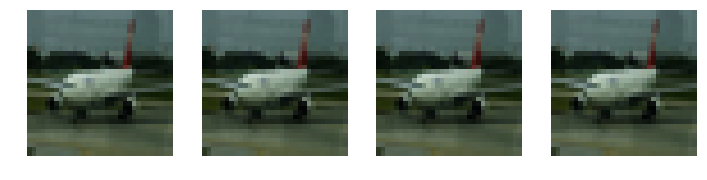

In [31]:
tfm = apply_lighting(contrast_tfm(scale=(0.3,3))())

# all the same
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(tfm(x()), ax)

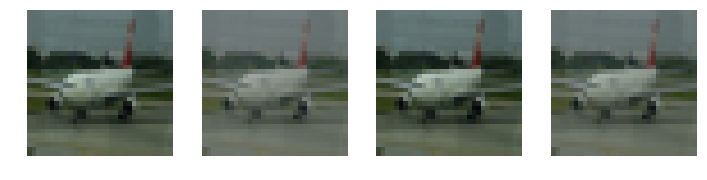

In [32]:
tfm = contrast_tfm(scale=(0.3,3), p=0.5)

# different
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_lighting(tfm())(x()), ax)

## Decorator and composition

In [33]:
#export
def reg_transform(func):
    setattr(sys.modules[func.__module__], f'{func.__name__}_tfm', make_tfm_func(func))
    return func

In [34]:
reg_transform(brightness)
reg_transform(contrast);

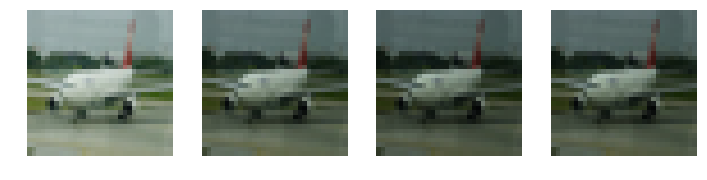

In [35]:
tfm = brightness_tfm(change=(0.25,0.75))
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_lighting(tfm())(x()), ax)

In [36]:
#export
def resolve_tfms(tfms): return [f() for f in listify(tfms)]

In [37]:
def apply_tfms(tfms):
    func = apply_lighting(compose(resolve_tfms(tfms)))
    return lambda x: func(x.clone())

In [38]:
x = train_ds[1][0]

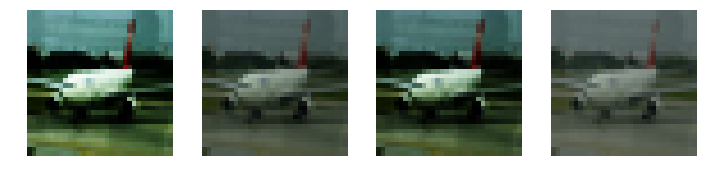

In [39]:
tfms = [contrast_tfm(scale=(0.3,3.0)),
        brightness_tfm(change=(0.35,0.65))]

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_tfms(tfms)(x), ax)

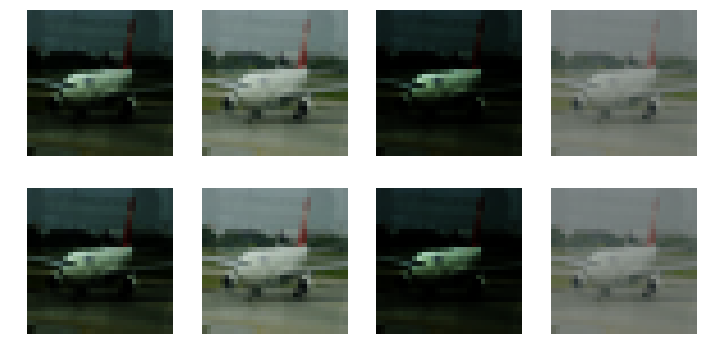

In [40]:
_,axes = plt.subplots(2,4, figsize=(12,6))
for i in range(4):
    tfm = apply_tfms(tfms)
    show_image(tfm(x), axes[0][i])
    show_image(tfm(x), axes[1][i])

In [41]:
del(brightness_tfm,contrast_tfm)

In [42]:
#export
@reg_transform
def brightness(x, change: uniform) -> TfmType.Lighting:  return x.add_(scipy.special.logit(change))

@reg_transform
def contrast(x, scale: log_uniform) -> TfmType.Lighting: return x.mul_(scale)

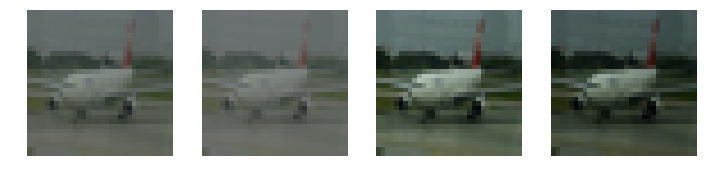

In [43]:
tfms = [contrast_tfm(scale=(0.3,3.0), p=0.5),
        brightness_tfm(change=(0.35,0.65), p=0.5)]

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_tfms(tfms)(x), ax)

# Affine

## Deterministic affine

In [44]:
#export
def grid_sample_nearest(input, coords, padding_mode='zeros'):
    if padding_mode=='border': coords.clamp(-1,1)
    bs,ch,h,w = input.size()
    sz = torch.tensor([w,h]).float()[None,None]
    coords.add_(1).mul_(sz/2)
    coords = coords[0].round_().long()
    if padding_mode=='zeros':
        mask = (coords[...,0] < 0) + (coords[...,1] < 0) + (coords[...,0] >= w) + (coords[...,1] >= h)
        mask.clamp_(0,1)
    coords[...,0].clamp_(0,w-1)
    coords[...,1].clamp_(0,h-1)
    result = input[...,coords[...,1],coords[...,0]]
    if padding_mode=='zeros': result[...,mask] = result[...,mask].zero_()
    return result

In [45]:
#export
def grid_sample(x, coords, mode='bilinear', padding_mode='reflect'):
    if mode=='nearest': return grid_sample_nearest(x[None], coords, padding_mode)[0]
    if padding_mode=='reflect': # Reflect padding isn't implemented in grid_sample yet
        coords[coords < -1] = coords[coords < -1].mul_(-1).add_(-2)
        coords[coords > 1] = coords[coords > 1].mul_(-1).add_(2)
        padding_mode='zeros'
    return F.grid_sample(x[None], coords, mode=mode, padding_mode=padding_mode)[0]

def affine_grid(x, matrix, size=None):
    if size is None: size = x.size()
    elif isinstance(size, int): size=(x.size(0), size, size)
    return F.affine_grid(matrix[None,:2], torch.Size((1,)+size))

In [46]:
def rotate(degrees):
    angle = degrees * math.pi / 180
    return [[cos(angle), -sin(angle), 0.],
            [sin(angle),  cos(angle), 0.],
            [0.        ,  0.        , 1.]]

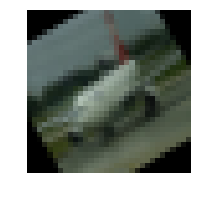

In [47]:
m = rotate(30)
m = x.new_tensor(m)
c = affine_grid(x, m)
img2 = grid_sample(x, c, padding_mode='zeros')
show_image(img2)

In [48]:
#export
def apply_affine(m=None, func=None):
    if m is None: m=torch.eye(3)
    def _inner(img, size=None, **kwargs):
        c = affine_grid(img,  img.new_tensor(m), size=size)
        if func is not None: c = func(c)
        return grid_sample(img, c, **kwargs)
    return _inner

In [49]:
def zoom(scale: uniform, row_pct = 0.5, col_pct = 0.5):
    s = 1-1/scale
    col_c = s * (2*col_pct - 1)
    row_c = s * (2*row_pct - 1)
    return [[1/scale, 0,       col_c],
            [0,       1/scale, row_c],
            [0,       0,       1.    ]]

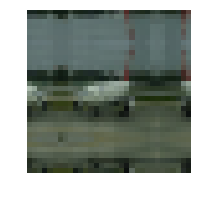

In [50]:
show_image(apply_affine(zoom(0.6))(x))

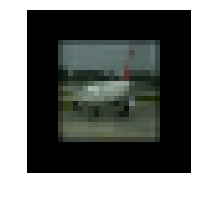

In [51]:
show_image(apply_affine(zoom(0.6))(x, padding_mode='zeros'))

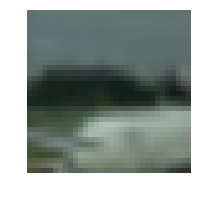

In [52]:
show_image(apply_affine(zoom(2, 0.2, 0.2))(x))

In [53]:
#export
def affines_mat(matrices=None):
    if matrices is None: matrices=[]
    matrices = [FloatTensor(m) for m in matrices if m is not None]
    return reduce(torch.matmul, matrices, torch.eye(3))

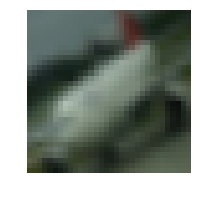

In [54]:
img2 = apply_affine(rotate(30))(x)
img2 = apply_affine(zoom(1.6))(img2)
show_image(img2)

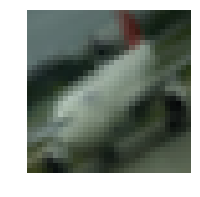

In [55]:
c = affines_mat([zoom(1.6), rotate(30)])
show_image(apply_affine(c)(x))

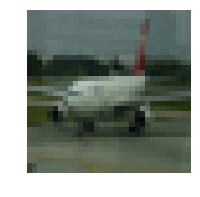

In [56]:
show_image(x)

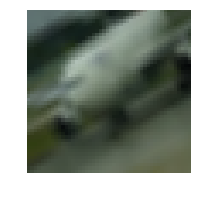

In [57]:
c = affines_mat([zoom(1.6, 0.8, 0.2), rotate(30)])
show_image(apply_affine(c)(x, size=48))

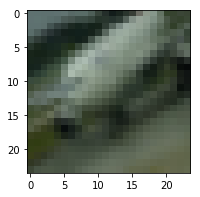

In [58]:
c = affines_mat([zoom(1.6, 0.8, 0.2), rotate(30)])
show_image(apply_affine(c)(x, size=24), hide_axis=False)

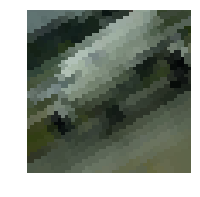

In [59]:
c = affines_mat([zoom(1.6, 0.8, 0.2), rotate(30)])
show_image(apply_affine(c)(x, size=48, mode='nearest'))

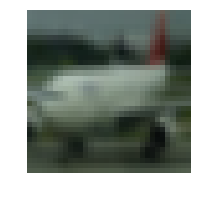

In [60]:
c = affines_mat([zoom(1.6)])
show_image(apply_affine(c)(x))

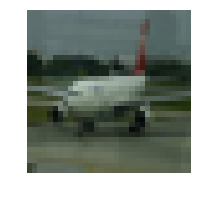

In [61]:
c = affines_mat()
show_image(apply_affine(c)(x))

## Random affine

In [66]:
#export
def make_p_affine(func):
    return lambda *args, p, **kwargs: func(*args,**kwargs) if p else None

def make_tfm_affine(func):
    def _inner(**kwargs): 
        res = lambda: make_p_affine(func)(**resolve_args(func, **kwargs))
        res.__annotations__ = func.__annotations__
        res.__annotations__['p'] = rand_bool
        return res
    return _inner

def dict_groupby(iterable, key=None):
    return {k:list(v) for k,v in itertools.groupby(sorted(iterable, key=key), key=key)}

def apply_tfms(tfms):
    grouped_tfms = dict_groupby(listify(tfms), lambda o: o.__annotations__['return'])
    start_tfms,affine_tfms,coord_tfms,pixel_tfms,lighting_tfms = [
        resolve_tfms(grouped_tfms.get(o)) for o in TfmType]
    lighting_func = apply_lighting(compose(lighting_tfms))
    affine_func = apply_affine(affines_mat(affine_tfms))
    return lambda x, **kwargs: lighting_func(affine_func(x.clone(), **kwargs))

In [67]:
#export
import inspect

def get_default_args(func):
    return {k: v.default
            for k, v in inspect.signature(func).parameters.items()
            if v.default is not inspect.Parameter.empty}

def resolve_args(func, **kwargs):
    def_args = get_default_args(func)
    for k,v in func.__annotations__.items():
        if k == 'return': continue
        if not k in kwargs and k in def_args:
            kwargs[k] = def_args[k]
        else:
            arg = listify(kwargs.get(k, 1))
            kwargs[k] = v(*arg)
    return kwargs

def reg_affine(func):
    setattr(sys.modules[__name__], f'{func.__name__}_tfm', make_tfm_affine(func))
    return func

In [68]:
#export
@reg_affine
def rotate(degrees: uniform) -> TfmType.Affine:
    angle = degrees * math.pi / 180
    return [[cos(angle), -sin(angle), 0.],
            [sin(angle),  cos(angle), 0.],
            [0.        ,  0.        , 1.]]

@reg_affine
def zoom(scale: uniform, row_pct:uniform = 0.5, col_pct:uniform = 0.5) -> TfmType.Affine:
    s = 1-1/scale
    col_c = s * (2*col_pct - 1)
    row_c = s * (2*row_pct - 1)
    return [[1/scale, 0,       col_c],
            [0,       1/scale, row_c],
            [0,       0,       1.    ]]

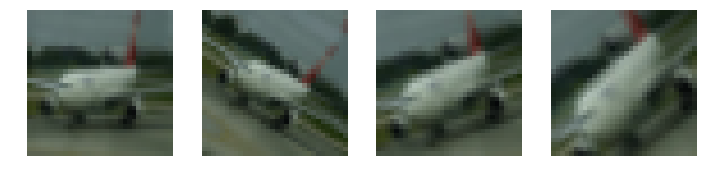

In [69]:
tfms = [rotate_tfm(degrees=(-45,45.), p=0.75),
        zoom_tfm(scale=(0.5,2.0), p=0.75)]

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_tfms(tfms)(x), ax)

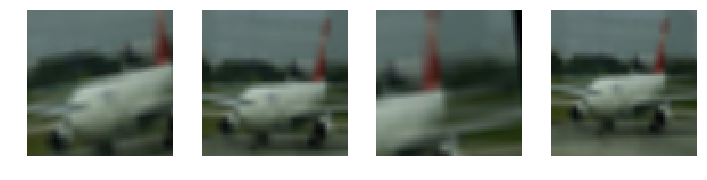

In [70]:
tfms = [rotate_tfm(degrees=(-45,45.), p=0.75),
        zoom_tfm(scale=(1.0,2.0), row_pct=(0,1.), col_pct=(0,1.))]

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_tfms(tfms)(x, size=64, padding_mode='zeros'), ax)

# Coord and pixel

## Jitter / apply_tfms

In [78]:
#export
@reg_transform
def jitter(x, magnitude: uniform) -> TfmType.Coord:
    return x.add_((torch.rand_like(x)-0.5)*magnitude*2)

def apply_tfms(tfms):
    grouped_tfms = dict_groupby(listify(tfms), lambda o: o.__annotations__['return'])
    start_tfms,affine_tfms,coord_tfms,pixel_tfms,lighting_tfms = [
        resolve_tfms(grouped_tfms.get(o)) for o in TfmType]
    lighting_func = apply_lighting(compose(lighting_tfms))
    affine_func = apply_affine(affines_mat(affine_tfms), func=compose(coord_tfms))
    start_func = compose(start_tfms)
    pixel_func = compose(pixel_tfms)
    return lambda x, **kwargs: pixel_func(lighting_func(affine_func(start_func(x.clone()), **kwargs)))

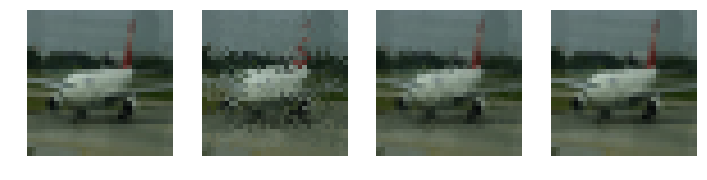

In [79]:
tfm = jitter_tfm(magnitude=(0,0.1))

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_tfms(tfm)(x), ax)

## Flip

In [80]:
#export
@reg_transform
def flip_lr(x) -> TfmType.Pixel: return x.flip(2)

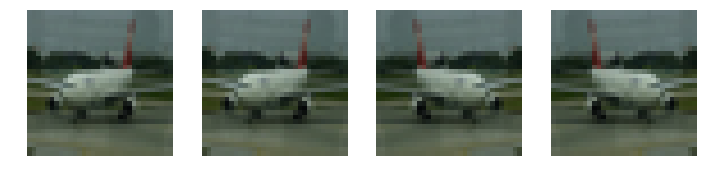

In [81]:
tfm = flip_lr_tfm(p=0.5)

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_tfms(tfm)(x), ax)

## Combine

In [82]:
tfms = [flip_lr_tfm(p=0.5),
        rotate_tfm(degrees=(-45,45.), p=0.5),
        zoom_tfm(scale=(0.4,1.5), p=0.8),
        contrast_tfm(scale=(0.5,2.0)),
        brightness_tfm(change=(0.3,0.7))
]

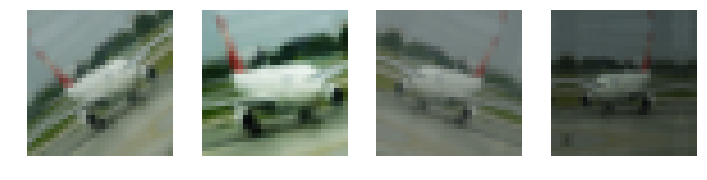

In [83]:
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_tfms(tfms)(x), ax)

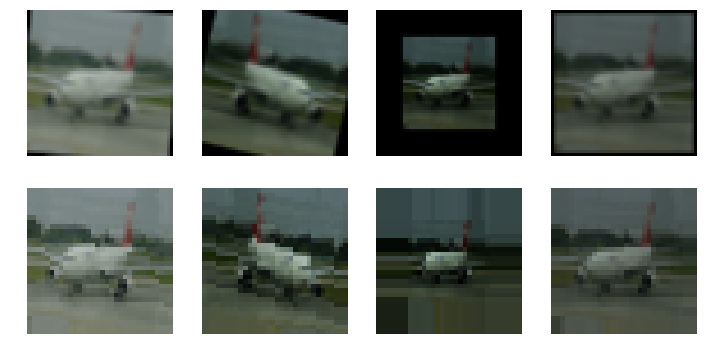

In [84]:
_,axes = plt.subplots(2,4, figsize=(12,6))
for i in range(4):
    tfm = apply_tfms(tfms)
    show_image(tfm(x, padding_mode='zeros', size=48), axes[0][i])
    show_image(tfm(x, mode='nearest'), axes[1][i])

# Fin